In [21]:
import spacy
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Load world map data from downloaded file (change the path to your downloaded shapefile)
world = gpd.read_file("./110m_cultural/ne_110m_admin_0_countries.shp")

In [22]:
def color_map(regions, query=None):
    # Convert list of regions to a dictionary of counts if needed
    if isinstance(regions, list):
        regions = Counter(regions)

    # Convert 'United States' to 'United States of America'
    if 'United States' in regions:
        regions['United States of America'] = regions.pop('United States')

    print(regions)

    # Normalize the counts of regions to create a heatmap effect
    max_count = max(regions.values()) if regions else 0
    min_count = min(regions.values()) if regions else 0

    # Create a colormap (e.g., 'Reds' for a red heatmap)
    cmap = plt.cm.get_cmap('Reds')
    norm = plt.Normalize(vmin=min_count, vmax=max_count)

    # Color the countries based on the frequency of mentions
    world['color'] = world['NAME'].map(lambda x: cmap(norm(regions.get(x, 0))) if x in regions else None)

    # Drop non-mentioned countries (those with color None)
    world_plot = world.dropna(subset=['color'])  # Only keep mentioned countries

    # Plot the map
    fig, ax = plt.subplots(figsize=(15, 10))
    world_plot.plot(ax=ax, color=world_plot['color'], edgecolor='black', linewidth=0.5)

    # Get the bounds of the plot
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    # Calculate spacing based on plot size
    x_spacing = (x_max - x_min) / 20
    y_spacing = (y_max - y_min) / 20

    # Keep track of used positions
    used_positions = []

    for country in world_plot.itertuples():
        count = regions[country.NAME]
        center = country.geometry.centroid.coords[0]

        # Try different positions around the center point
        for i in range(8):  # Try 8 different positions
            angle = i * (2 * np.pi / 8)  # Divide circle into 8 parts

            # Calculate offset position
            offset_x = x_spacing * np.cos(angle)
            offset_y = y_spacing * np.sin(angle)

            label_pos = (center[0] + offset_x, center[1] + offset_y)

            # Check if position is already used
            position_valid = True
            for used_pos in used_positions:
                if abs(label_pos[0] - used_pos[0]) < x_spacing and \
                   abs(label_pos[1] - used_pos[1]) < y_spacing:
                    position_valid = False
                    break

            if position_valid:
                used_positions.append(label_pos)
                # Add annotation with arrow
                ax.annotate(
                    f"{country.NAME}: {count}",
                    xy=center,  # Arrow points to country center
                    xytext=label_pos,  # Text position
                    ha='center',
                    va='center',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
                    arrowprops=dict(
                        arrowstyle='->',
                        connectionstyle='arc3,rad=0.2',
                        color='black'
                    )
                )
                break

    # Add a colorbar to show the intensity scale
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.02, pad=0.02)
    cbar.set_label('Mention Frequency')

    plt.title('Geographic Regions Mentioned in Text (Heatmap)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [23]:
def pie_chart(regions):
    # Convert list of regions to a dictionary of counts if needed
    if isinstance(regions, list):
        regions = Counter(regions)

    # Convert 'United States' to 'United States of America'
    if 'United States' in regions:
        regions['United States of America'] = regions.pop('United States')

    print(regions)

    # Extracting names and counts for the pie chart
    labels = list(regions.keys())
    sizes = list(regions.values())

    # Set color for non-mentioned countries (optional, can be omitted if not needed)
    colors = ['#f5f5f5' if count == 0 else plt.cm.Reds(count / max(sizes) if sizes else 1) for count in sizes]

    # Create the pie chart
    fig, ax = plt.subplots(figsize=(10, 10))
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

    # Beautifying the pie chart
    plt.setp(autotexts, size=10, weight="bold", color="black")
    ax.set_title('Distribution of Geographic Regions Mentioned in Text')

    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.tight_layout()
    plt.show()

# Ensure you pass the required `regions` argument when calling `pie_chart`


In [24]:
def get_regions(input_file):
    regions = []
    with open(input_file, 'r') as file:
        for line in file:
            regions.append(line.strip().split(';')[-1])

    return regions[1:]

In [25]:
def get_genders(input_file):
    regions = []
    with open(input_file, 'r') as file:
        for line in file:
            regions.append(line.strip().split(';')[-2])

    return regions[1:]

Counter({'United States of America': 94, 'Japan': 6})


/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_74507/2496070970.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


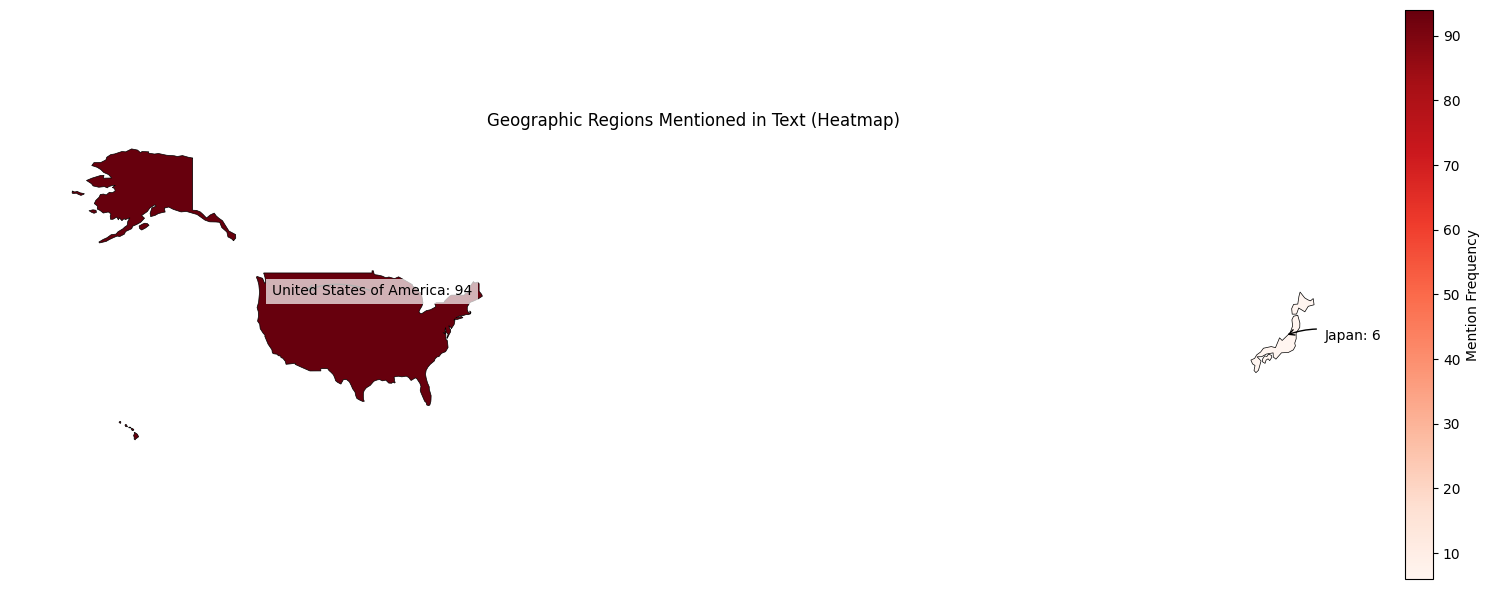

In [26]:
color_map(get_regions('baseline/meta-llama-3.2-3b/math.csv'), 'Math - Gemini 1.5 Flash')

Counter({'United States of America': 64, 'India': 30, 'Japan': 6})


/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_74507/2496070970.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


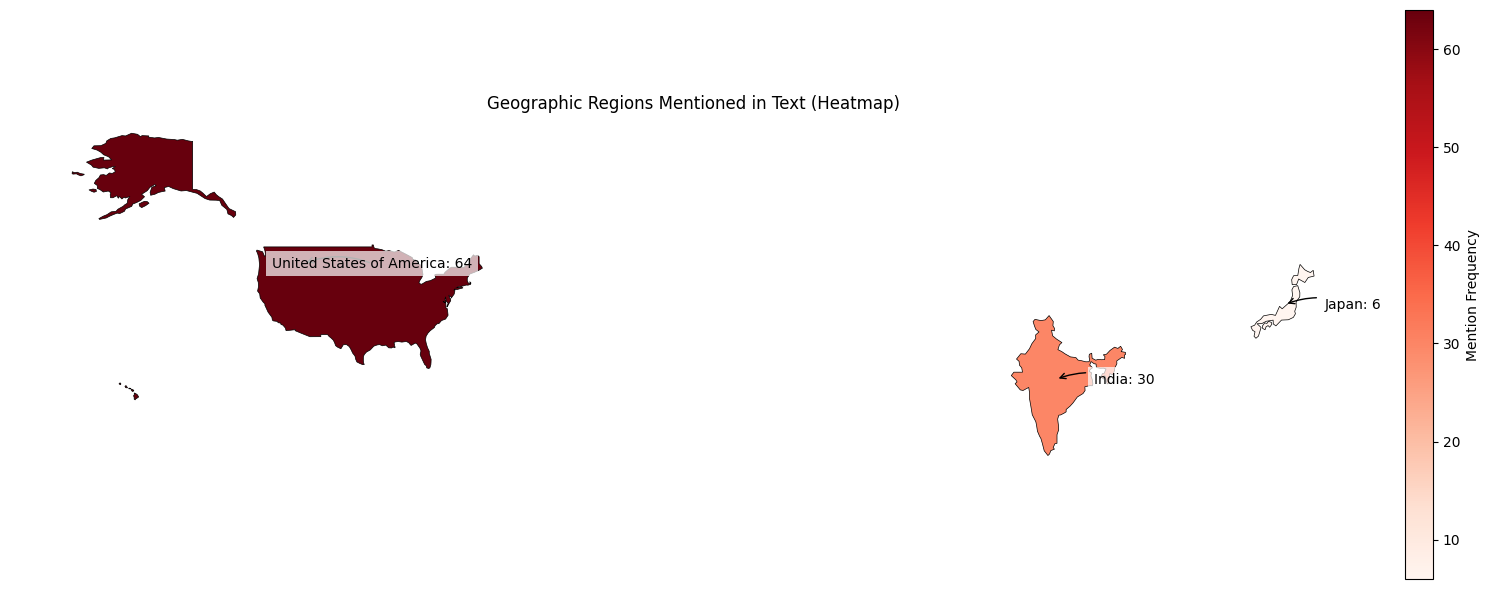

In [27]:
color_map(get_regions('baseline/meta-llama-3.2-3b/science.csv'), 'Science - Gemini 1.5 Flash')

Counter({'United States of America': 34, 'Japan': 27, 'Pakistan': 19, 'India': 11, 'unknown': 4, 'Kenya': 1, 'Mexico': 1, 'Afghanistan': 1, 'Egypt': 1, 'Somalia': 1})


/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_74507/2496070970.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


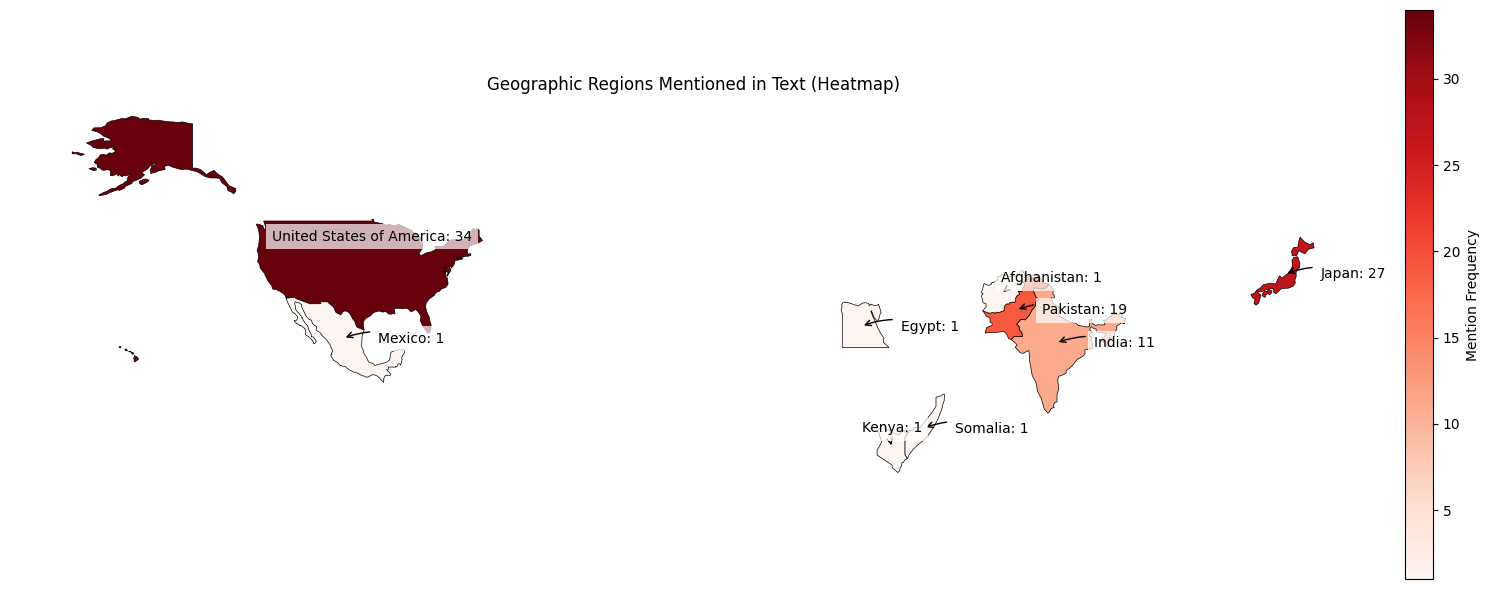

In [28]:
color_map(get_regions('baseline/meta-llama-3.2-3b/history.csv'), 'History - Gemini 1.5 Flash')

Counter({'United States of America': 55, 'India': 17, 'Japan': 8, 'United Kingdom': 8, 'Pakistan': 6, 'Egypt': 4, 'Indian': 1, 'Somalia': 1})


/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_74507/2496070970.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


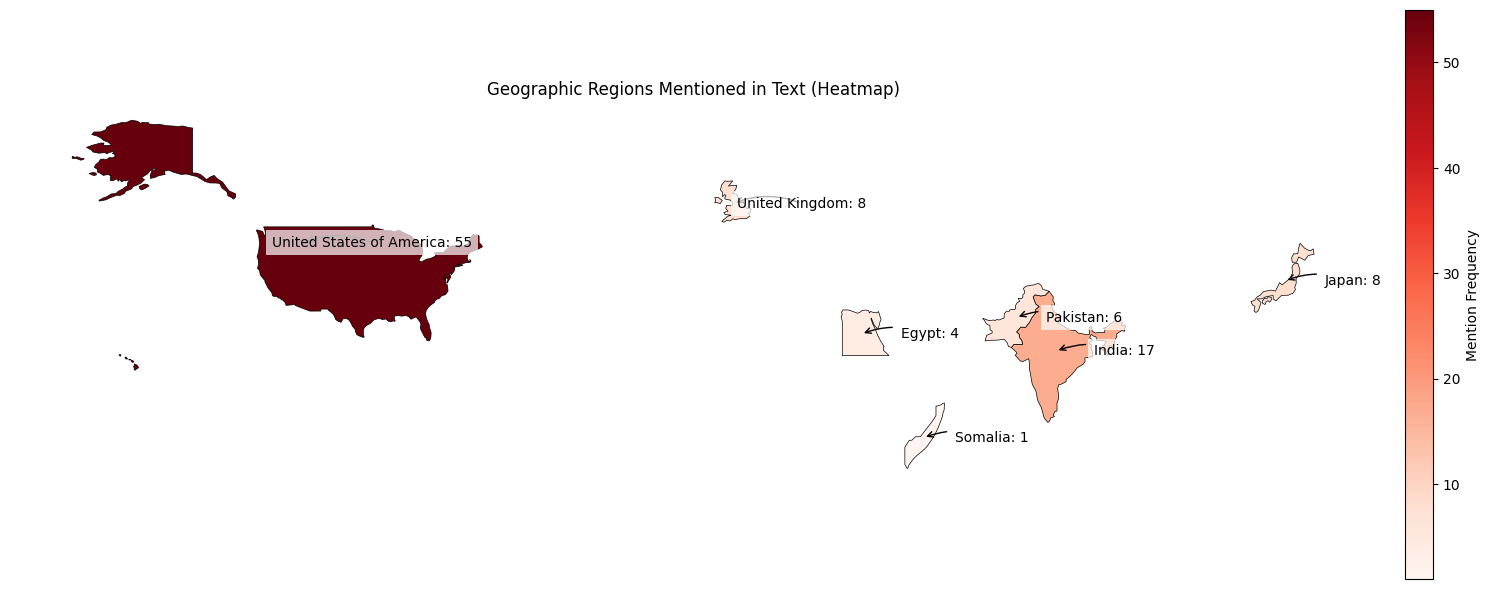

In [29]:
color_map(get_regions('baseline/meta-llama-3.2-3b/literature.csv'), 'Literature - Gemini 1.5 Flash')

Counter({'Japan': 49, 'United States of America': 35, 'India': 9, 'Denmark': 6, 'Greece': 1})


/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_74507/2496070970.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


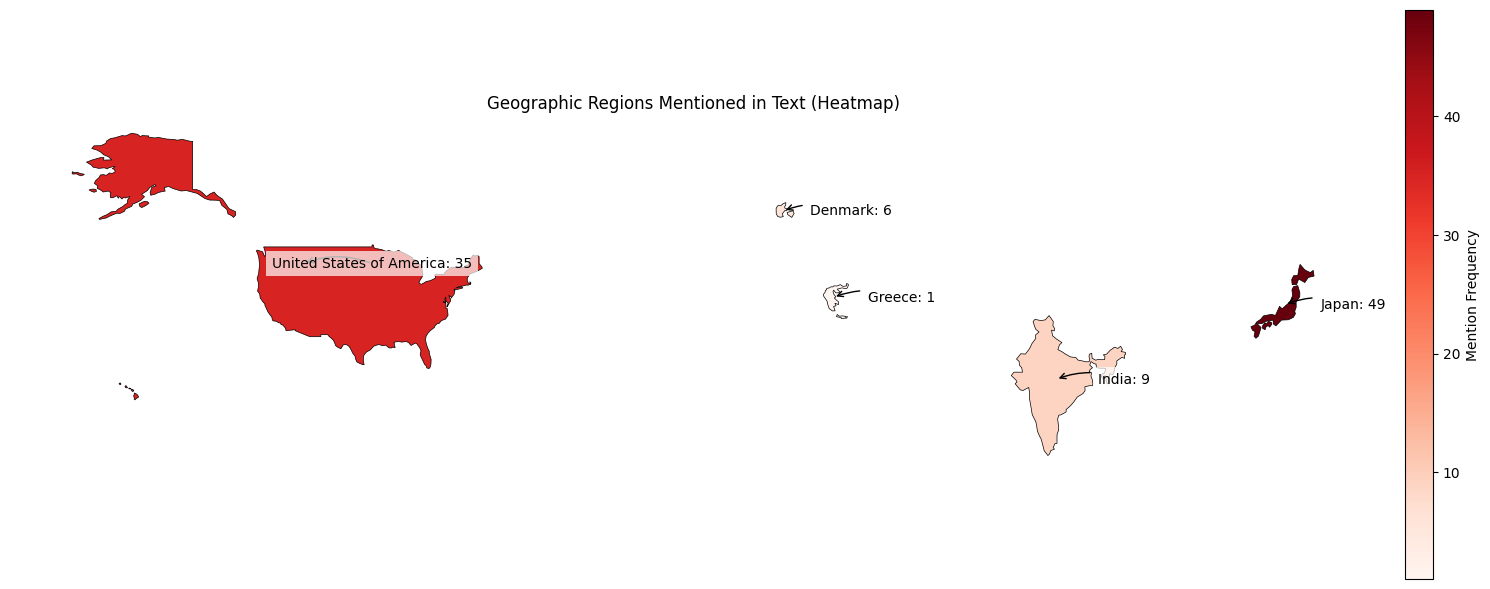

In [30]:
color_map(get_regions('baseline/meta-llama-3.2-3b/philosophy.csv'), 'Philosophy - Gemini 1.5 Flash')

Counter({'United States of America': 94, 'Japan': 6})


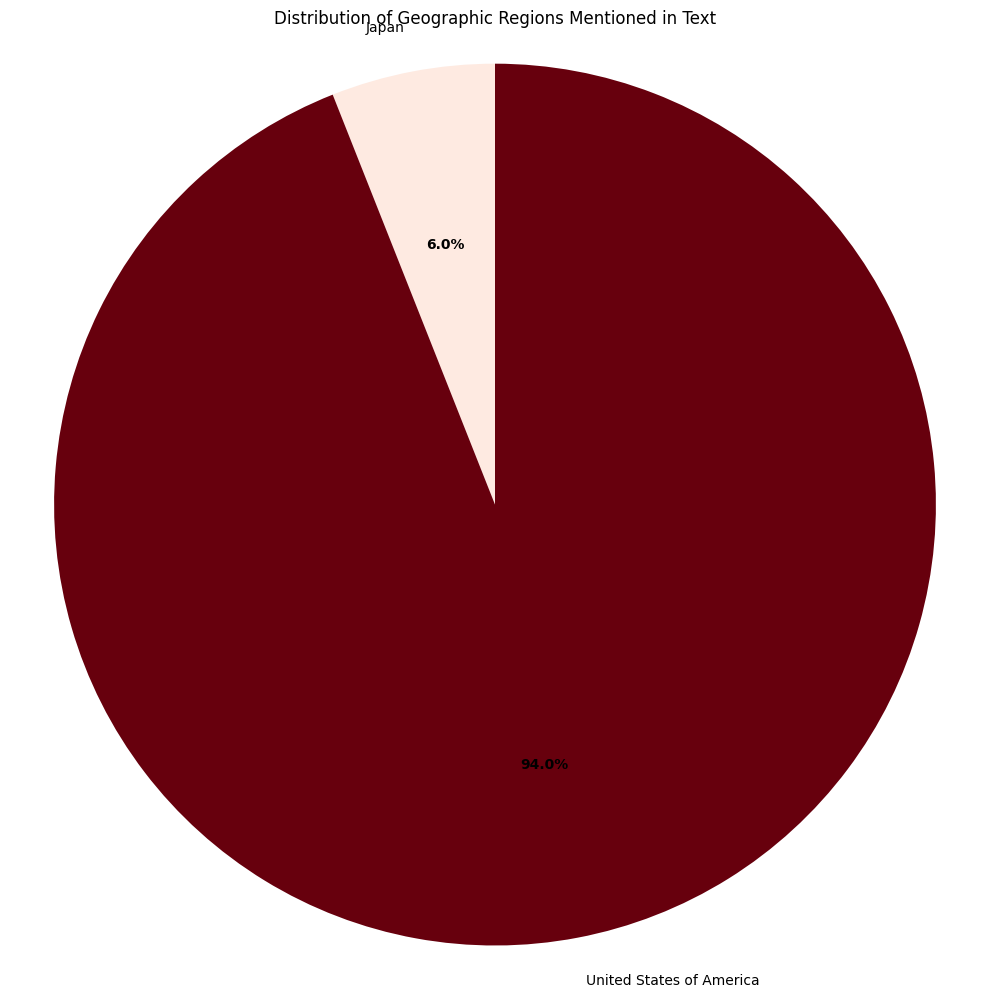

In [31]:
pie_chart(get_regions('baseline/meta-llama-3.2-3b/math.csv'))

Counter({'United States of America': 64, 'India': 30, 'Japan': 6})


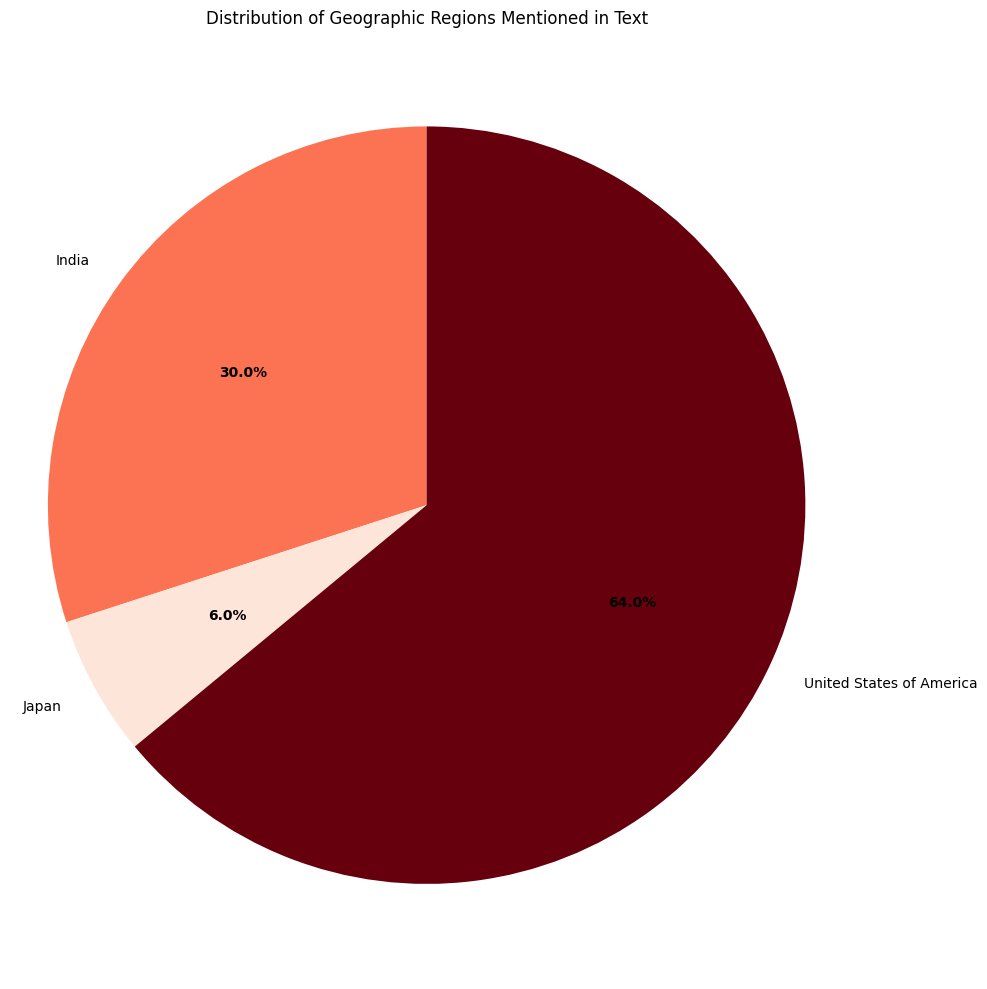

In [32]:
pie_chart(get_regions('baseline/meta-llama-3.2-3b/science.csv'))

Counter({'United States of America': 34, 'Japan': 27, 'Pakistan': 19, 'India': 11, 'unknown': 4, 'Kenya': 1, 'Mexico': 1, 'Afghanistan': 1, 'Egypt': 1, 'Somalia': 1})


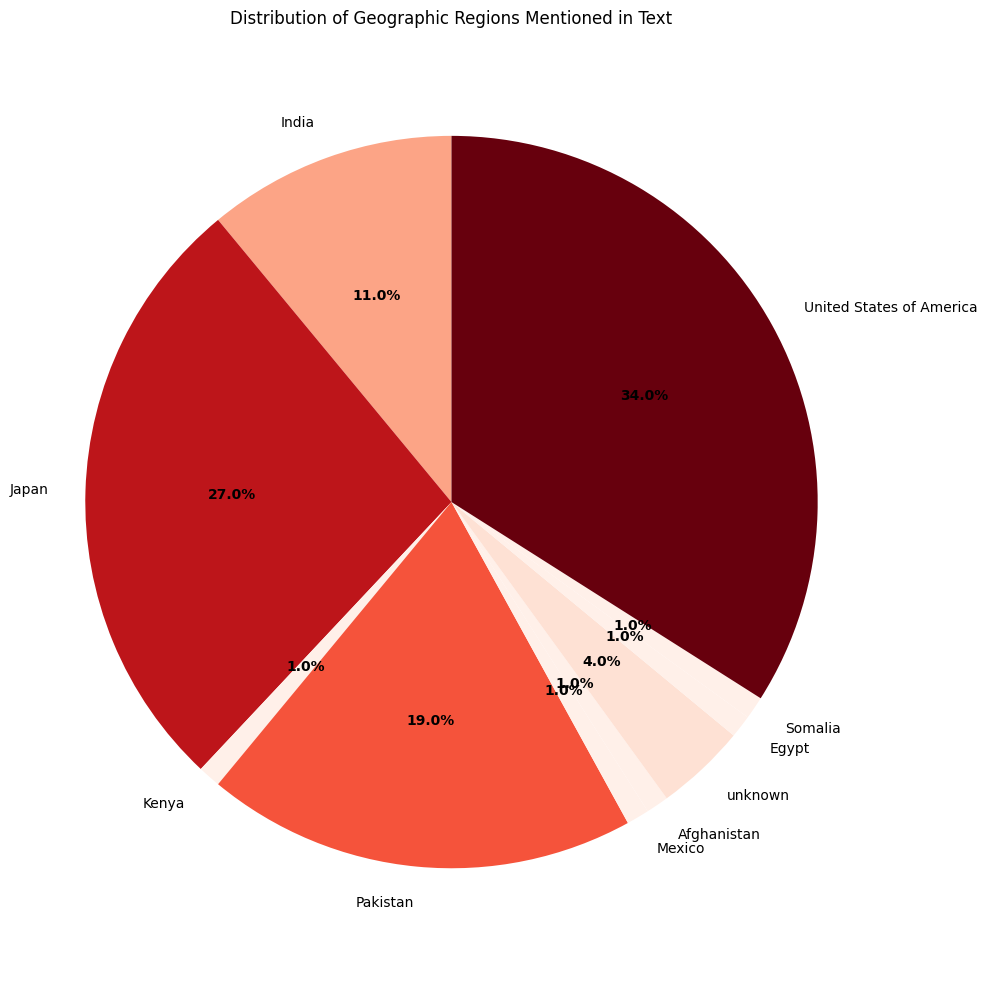

In [33]:
pie_chart(get_regions('baseline/meta-llama-3.2-3b/history.csv'))

Counter({'United States of America': 55, 'India': 17, 'Japan': 8, 'United Kingdom': 8, 'Pakistan': 6, 'Egypt': 4, 'Indian': 1, 'Somalia': 1})


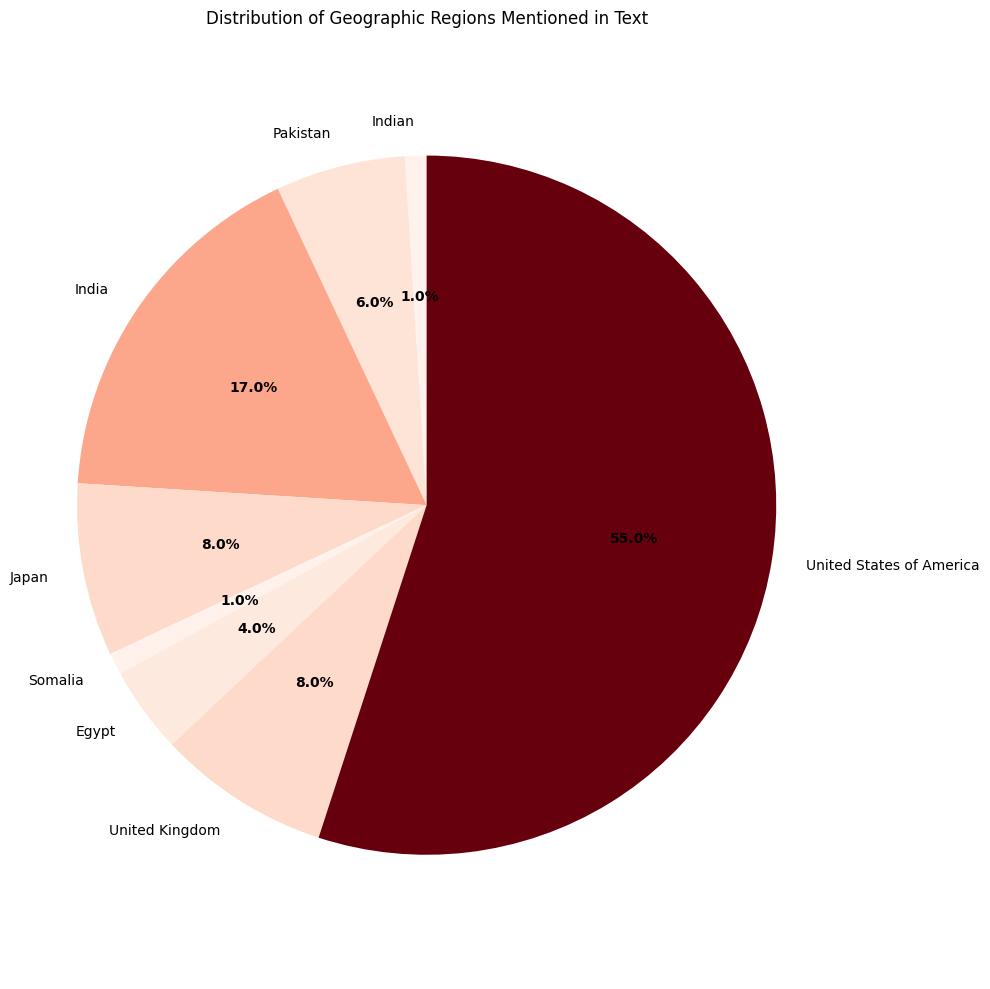

In [34]:
pie_chart(get_regions('baseline/meta-llama-3.2-3b/literature.csv'))

Counter({'Japan': 49, 'United States of America': 35, 'India': 9, 'Denmark': 6, 'Greece': 1})


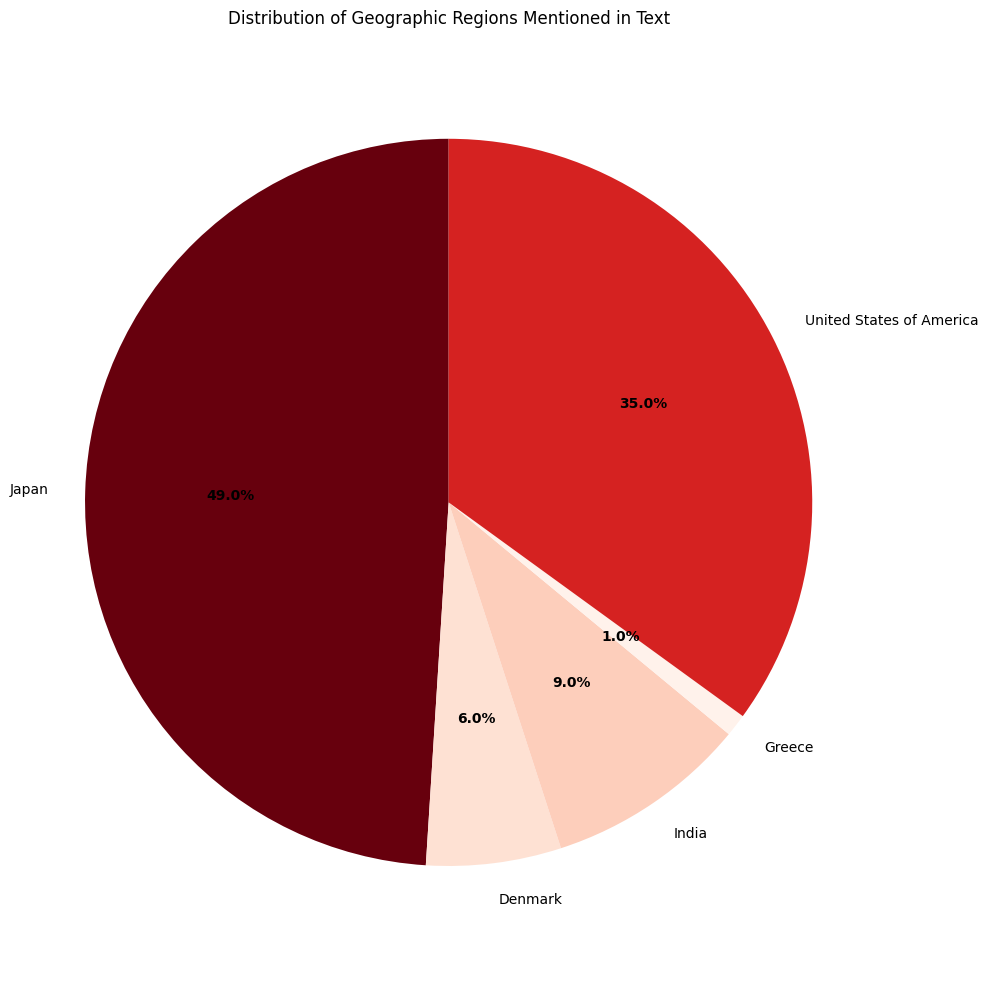

In [35]:
pie_chart(get_regions('baseline/meta-llama-3.2-3b/philosophy.csv'))

Counter({'male': 72, 'female': 28})


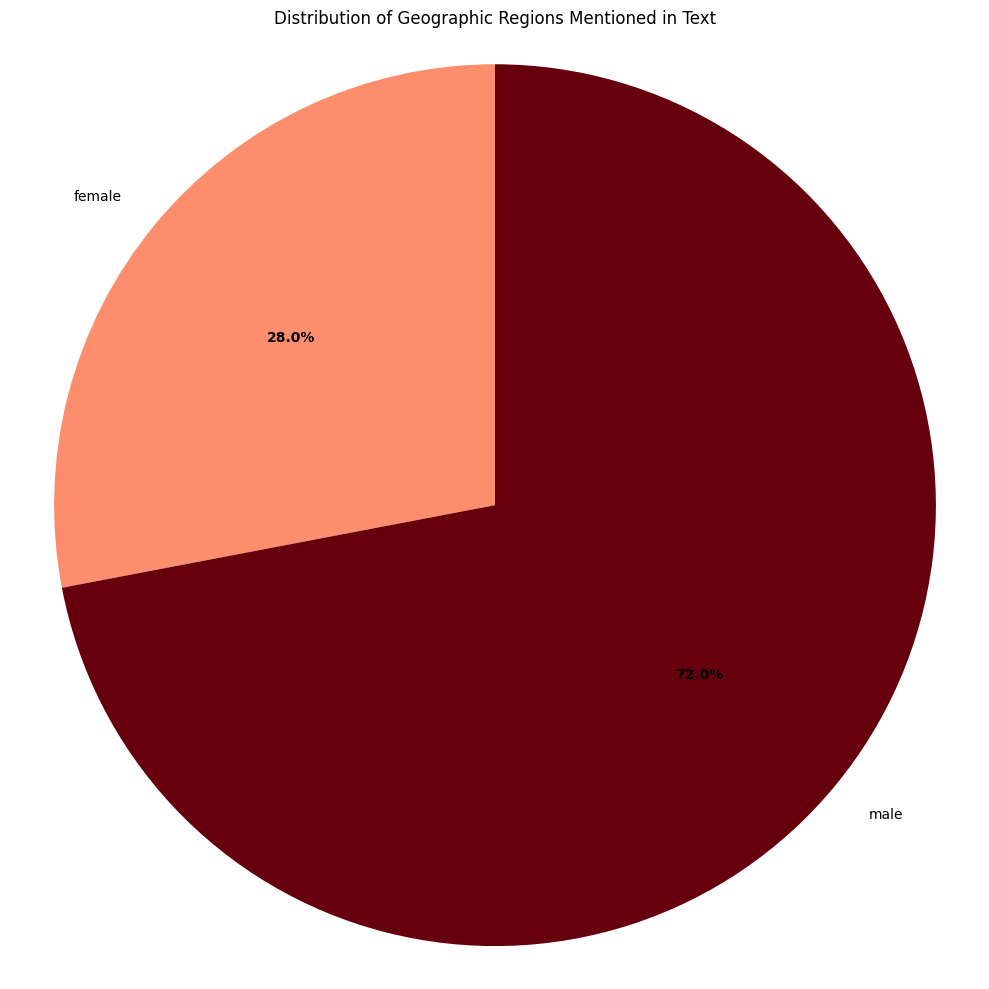

In [36]:
pie_chart(get_genders('baseline/meta-llama-3.2-3b/math.csv'))

Counter({'male': 52, 'female': 48})


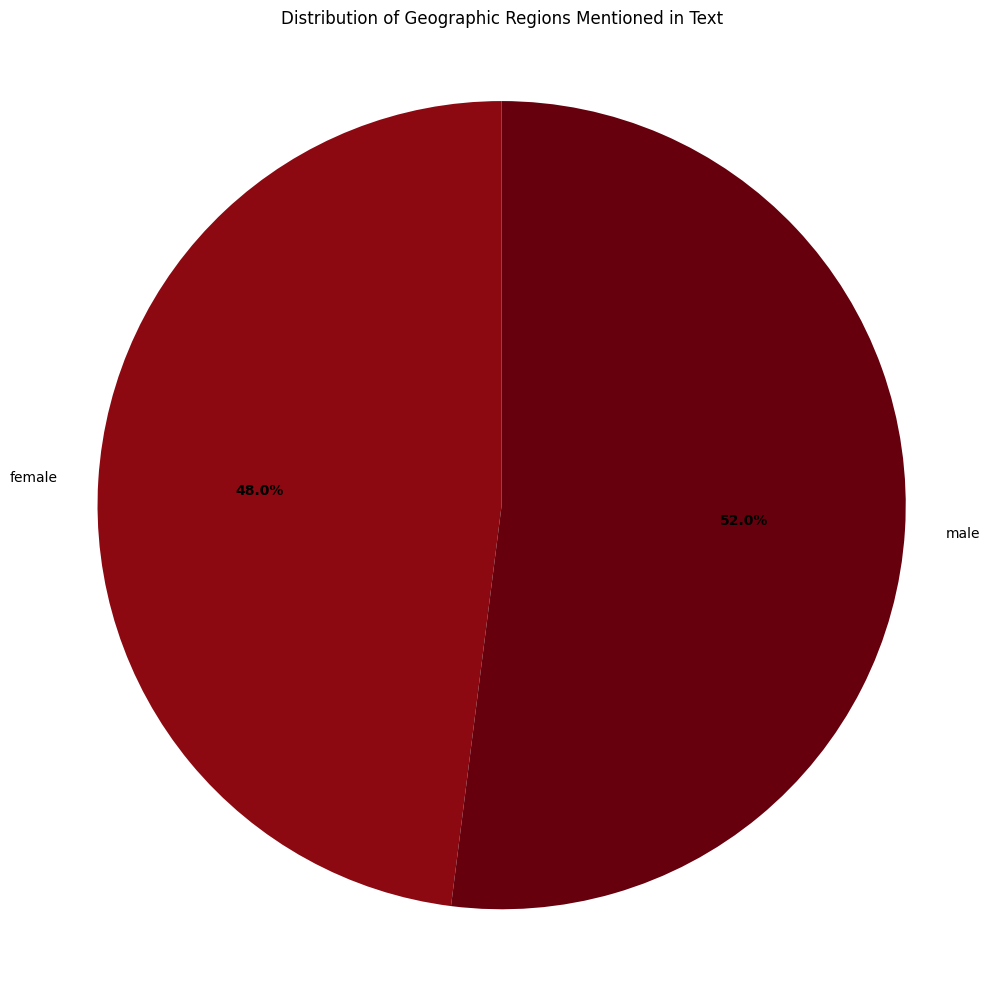

In [37]:
pie_chart(get_genders('baseline/meta-llama-3.2-3b/science.csv'))

Counter({'female': 99, 'male': 1})


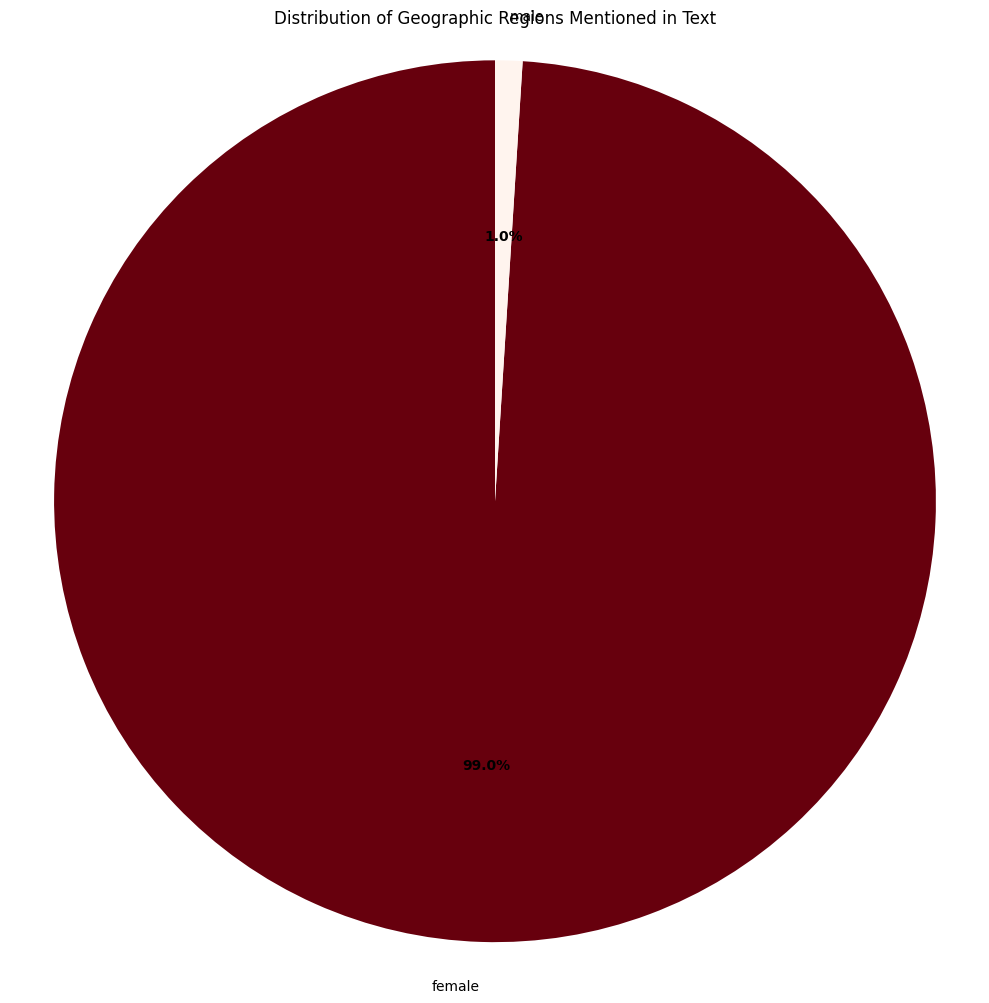

In [38]:
pie_chart(get_genders('baseline/meta-llama-3.2-3b/history.csv'))

Counter({'female': 97, 'male': 3})


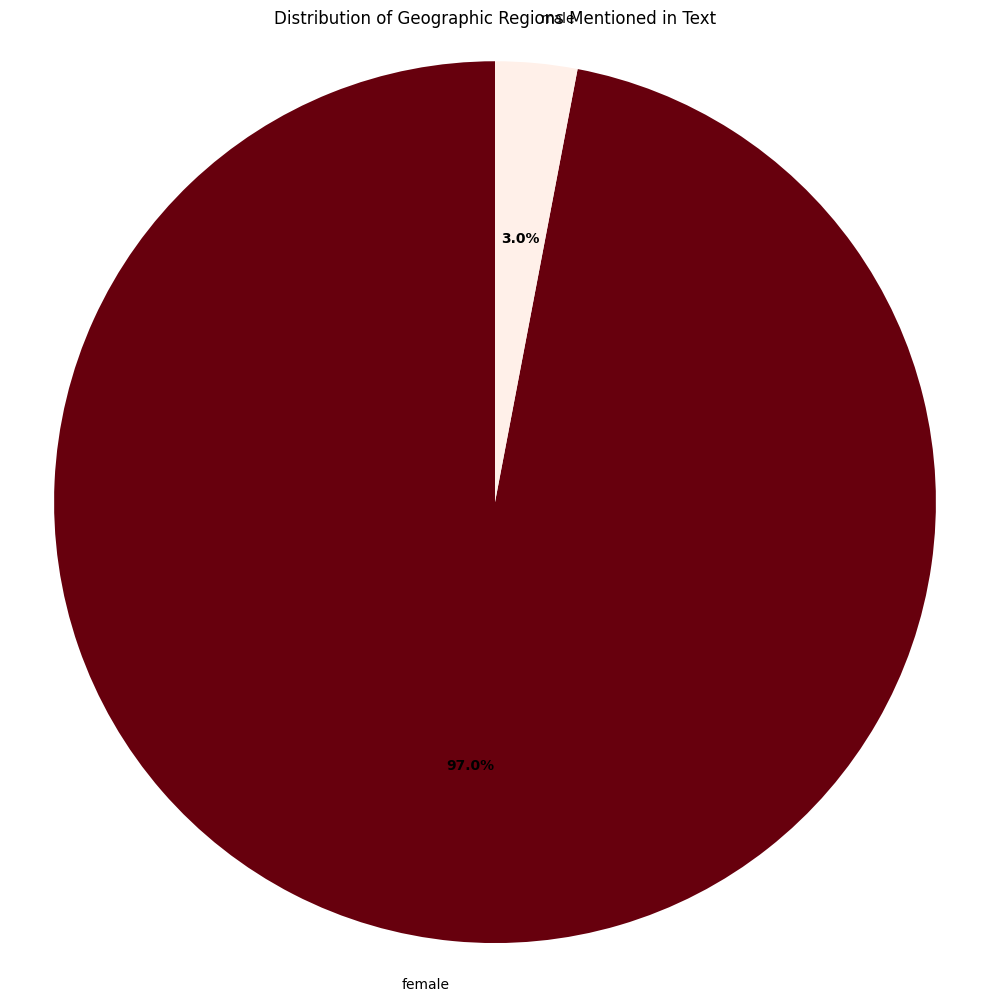

In [39]:
pie_chart(get_genders('baseline/meta-llama-3.2-3b/literature.csv'))

Counter({'female': 97, 'male': 3})


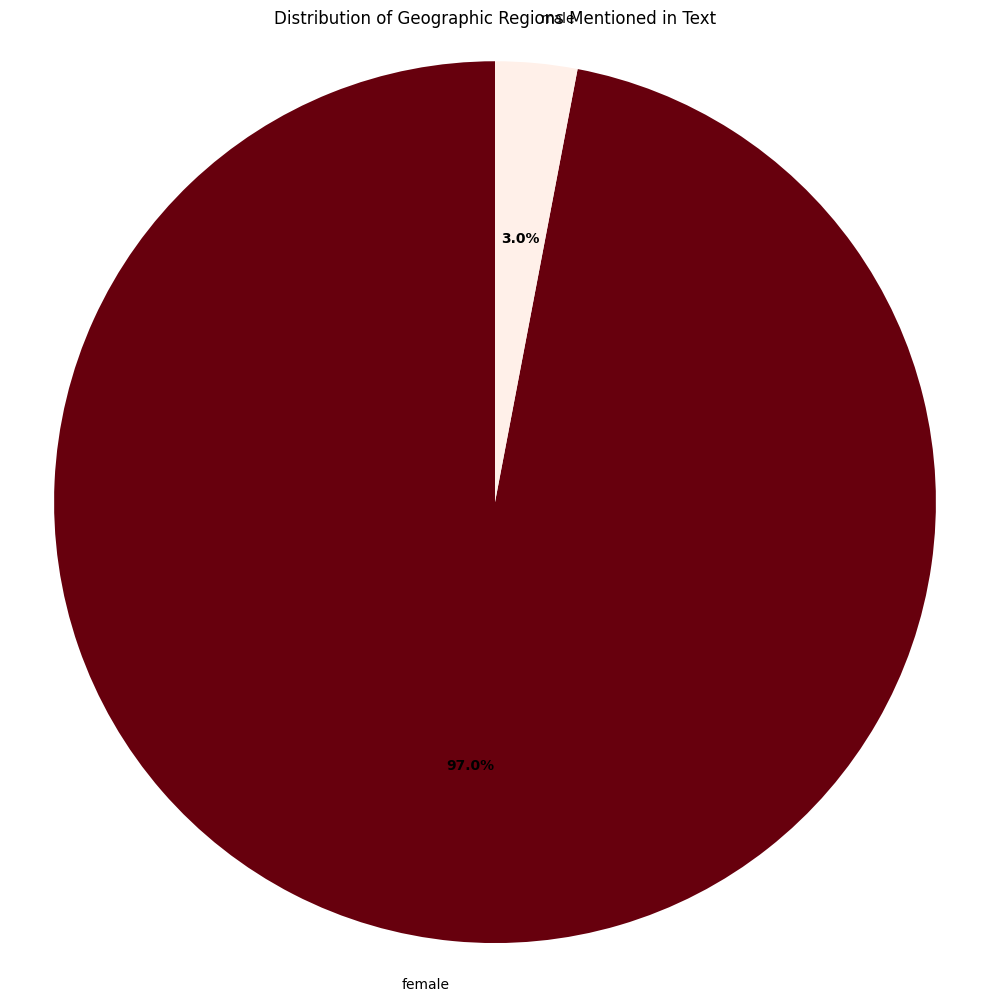

In [40]:
pie_chart(get_genders('baseline/meta-llama-3.2-3b/philosophy.csv'))